In [39]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import scipy
from scipy.optimize import curve_fit
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
sys.path.append('../')
import utils

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing results locally

In [484]:
import dataset
import training
from model import RecurrentModel
import time

In [485]:
with open('../pickles/carry_tables/all_tables_d1_b2-6.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [486]:
b = 3
tables = all_tables[b]

In [487]:
table = tables[((0,)*b,)*b]

In [488]:
training_dataloader, testing_dataloader = dataset.prepare(b, 6, table, semanticity=True, unit=1, batch_size=32, split_type='OOD', split_depth=3, sample=True)

In [489]:
model = RecurrentModel(b, 2*b, 'RNN')
loss, training_acc, testing_acc = training.eval(
    model, training_dataloader, testing_dataloader,
    epochs=5000, lr=0.005, log_interval=100, print_loss_and_acc=True
)

t = 0
loss = 1.094130, training_acc = 0.000, testing_acc = 0.000

t = 100
loss = 0.907513, training_acc = 0.000, testing_acc = 0.000

t = 200
loss = 0.739505, training_acc = 0.000, testing_acc = 0.000

t = 300
loss = 0.690231, training_acc = 0.000, testing_acc = 0.000

t = 400
loss = 0.669501, training_acc = 0.111, testing_acc = 0.000

t = 500
loss = 0.665163, training_acc = 0.000, testing_acc = 0.000

t = 600
loss = 0.648868, training_acc = 0.074, testing_acc = 0.000

t = 700
loss = 0.643394, training_acc = 0.037, testing_acc = 0.000

t = 800
loss = 0.635315, training_acc = 0.037, testing_acc = 0.000

t = 900
loss = 0.599531, training_acc = 0.074, testing_acc = 0.000

t = 1000
loss = 0.586044, training_acc = 0.000, testing_acc = 0.000

t = 1100
loss = 0.598213, training_acc = 0.000, testing_acc = 0.000

t = 1200
loss = 0.600575, training_acc = 0.037, testing_acc = 0.000

t = 1300
loss = 0.580347, training_acc = 0.037, testing_acc = 0.000

t = 1400
loss = 0.609215, training_acc = 0.037

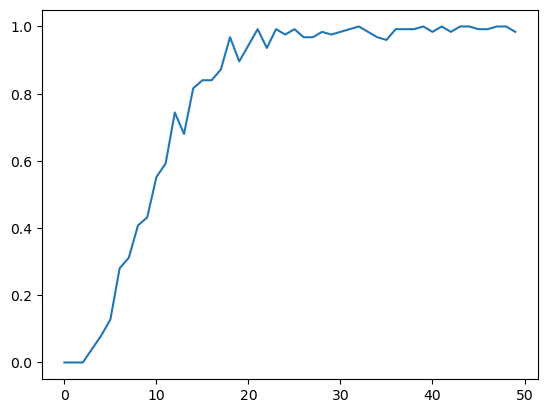

In [177]:
plt.plot(training_acc)

In [494]:
lrs = np.linspace(0.001, 0.005, 5)
# lrs = [0.001, 0.005, 0.01, 0.05, 0.1]
n_trials = 2

# t0 = time.time()
test_acc_vs_lr = {}
for lr in lrs:
    print('lr =', lr, '\n')
    avg_testing_acc = np.zeros(50)
    for _ in range(n_trials):
        model = RecurrentModel(b, 3*b, 'RNN')
        loss, training_acc, testing_acc = training.eval(
            model, training_dataloader, testing_dataloader, lr=lr,
            epochs=5000, log_interval=100, print_loss_and_acc=True
        )
        avg_testing_acc += 1/n_trials * np.array(testing_acc)
    test_acc_vs_lr[lr] = avg_testing_acc
# print(time.time() - t0)

lr = 0.001 

t = 0
loss = 1.036555, training_acc = 0.000, testing_acc = 0.000

t = 100
loss = 0.928081, training_acc = 0.000, testing_acc = 0.000

t = 200
loss = 0.724404, training_acc = 0.000, testing_acc = 0.000

t = 300
loss = 0.698211, training_acc = 0.037, testing_acc = 0.000

t = 400
loss = 0.668378, training_acc = 0.037, testing_acc = 0.000

t = 500
loss = 0.680446, training_acc = 0.037, testing_acc = 0.000

t = 600
loss = 0.626704, training_acc = 0.000, testing_acc = 0.000

t = 700
loss = 0.638370, training_acc = 0.074, testing_acc = 0.000

t = 800
loss = 0.603374, training_acc = 0.037, testing_acc = 0.000

t = 900
loss = 0.649920, training_acc = 0.037, testing_acc = 0.000

t = 1000
loss = 0.611258, training_acc = 0.000, testing_acc = 0.000

t = 1100
loss = 0.591453, training_acc = 0.074, testing_acc = 0.000

t = 1200
loss = 0.615544, training_acc = 0.000, testing_acc = 0.000

t = 1300
loss = 0.637886, training_acc = 0.074, testing_acc = 0.000

t = 1400
loss = 0.566140, trainin

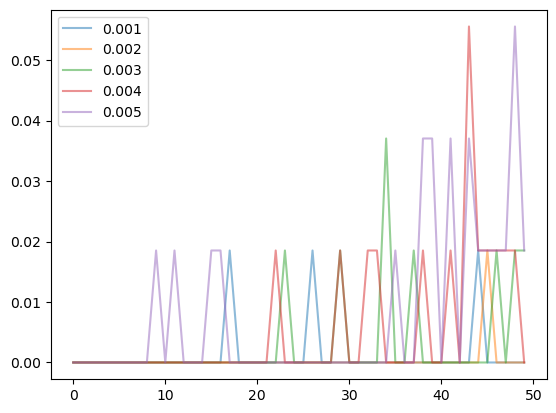

In [495]:
for lr, testing_acc in test_acc_vs_lr.items():
    plt.plot(testing_acc, alpha=0.5, label=lr)
plt.legend()

For b=3, lr=0.02,0.04 achieved fastest results (w/ batch_size=16)

For b=4, lr=0.04 achieved fastest results (w/ batch_size=64)


Seems like batch_size=16 is sweet spot for base 3, and batch_size=64 is sweet spot for base 4, 5

In [616]:
with open(f'../pickles/learning_metrics/learning_metrics3_RNN3b_10trials.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

Text(0, 0.5, 'Test Accuracy')

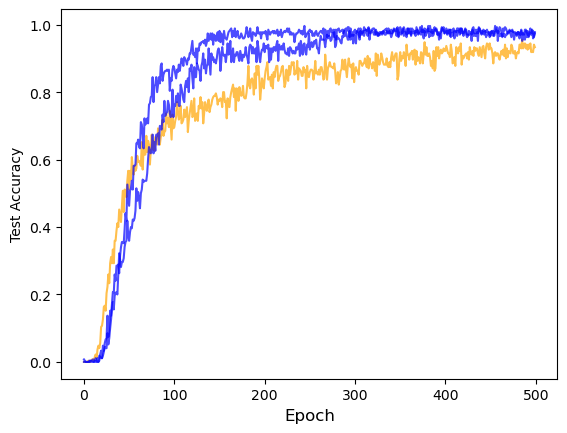

In [617]:
for dc in learning_metrics.keys():
    test_acc = learning_metrics[dc]['testing_acc']
    est_dim = est_dim_box_vs_depth[3][dc][3]
    if len(np.unique(all_tables[3][dc])) == 2:
        unit, = plt.plot(test_acc, color='blue', alpha=0.7, label='Single Value', zorder=3)
    elif est_dim > 1.25 and est_dim < 1.5:
        special_non_unit, = plt.plot(test_acc, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
    else:
        non_unit, = plt.plot(test_acc, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Accuracy')

## Plot Learning Speeds

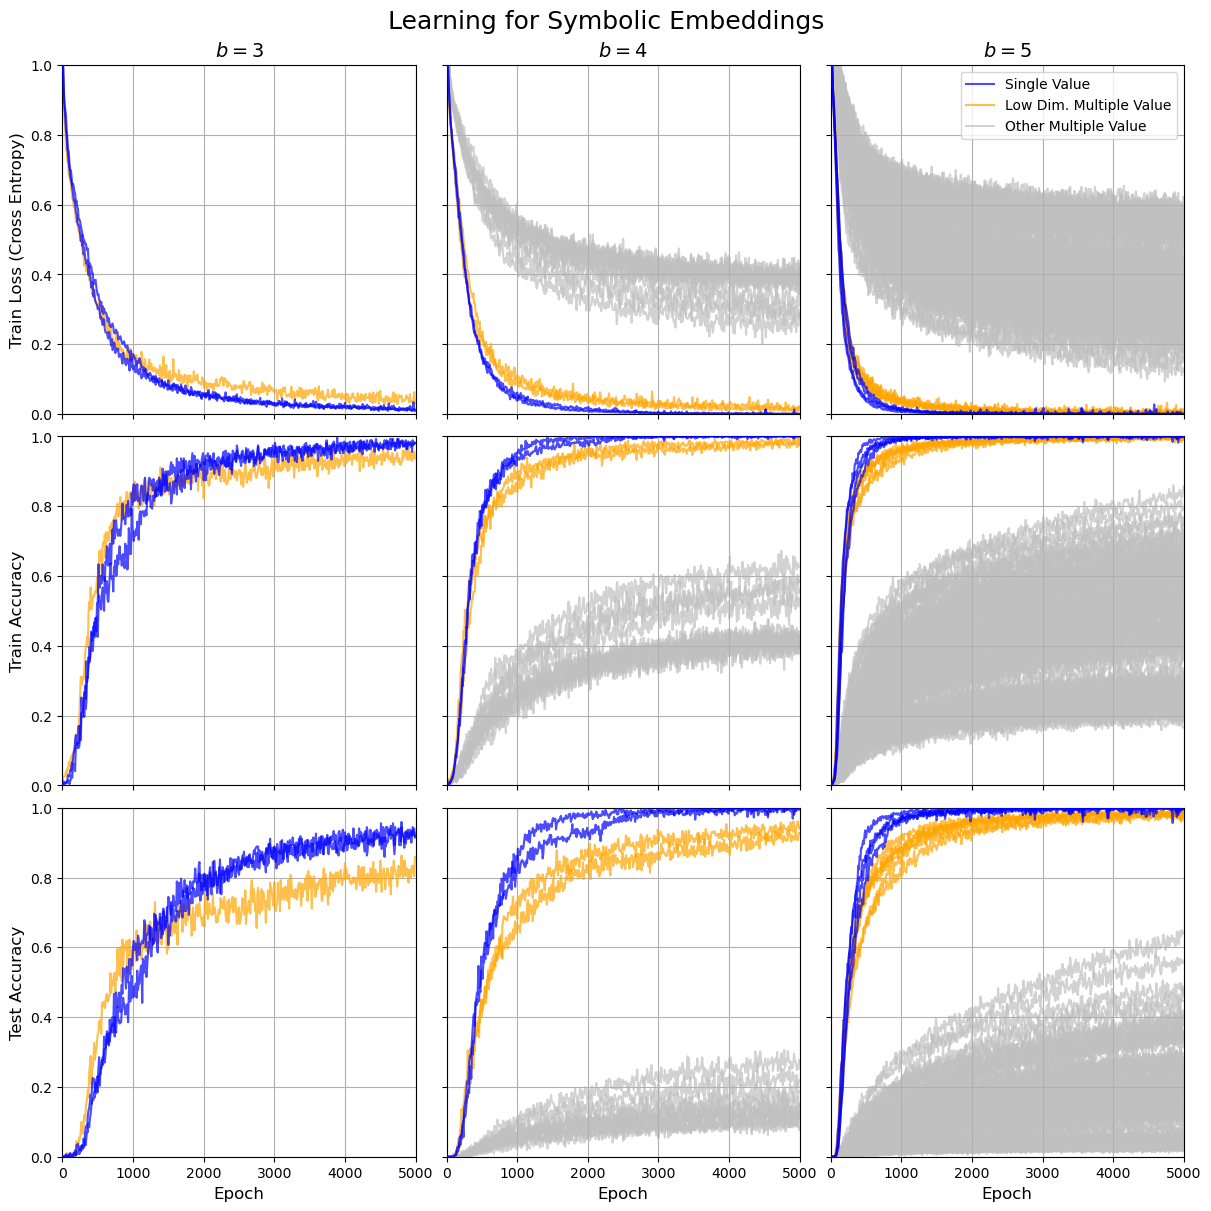

In [771]:
# create subplots, title figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Learning for Symbolic Embeddings', fontsize=18)

for i in range(3):
    for j in range(3):

        # get b, learning speeds
        b = i + 3
        with open(f'../pickles/learning_metrics/learning_metrics{b}_RNN_10trials.pickle', 'rb') as f:
            learning_metrics = pickle.load(f)

        # get ax, set basic formatting
        ax = axes[j, i]
        ax.grid(True)
        ax.set_xlim(0, 500)
        ax.set_ylim(0)
        ax.set_xticks(np.linspace(0, 500, 6), np.linspace(0, 5000, 6).astype('int'))

        # loss plot
        if j == 0:
            ax.set_title(f'$b = {b}$', fontsize=14)
            for dc in learning_metrics.keys():
                loss = learning_metrics[dc]['loss']
                est_dim = est_dim_box_vs_depth[b][dc][3]
                if len(np.unique(all_tables[b][dc])) == 2:
                    unit, = ax.plot(loss, color='blue', alpha=0.7, label='Single Value', zorder=3)
                elif est_dim > 1.25 and est_dim < 1.5:
                    special_non_unit, = ax.plot(loss, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
                else:
                    non_unit, = ax.plot(loss, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
            if i == 0:
                ax.set_ylabel('Train Loss (Cross Entropy)', fontsize=12)
            elif i == 2:
                ax.legend(handles=[unit, special_non_unit, non_unit])
    
        # training accuracy plot
        if j == 1:
            for dc in learning_metrics.keys():
                train_acc = learning_metrics[dc]['training_acc']
                est_dim = est_dim_box_vs_depth[b][dc][3]
                if len(np.unique(all_tables[b][dc])) == 2:
                    unit, = ax.plot(train_acc, color='blue', alpha=0.7, label='Single Value', zorder=3)
                elif est_dim > 1.25 and est_dim < 1.5:
                    special_non_unit, = ax.plot(train_acc, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
                else:
                    non_unit, = ax.plot(train_acc, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
            if i == 0:
                ax.set_ylabel('Train Accuracy', fontsize=12)
    
        # testing accuracy plot
        if j == 2:
            for dc in learning_metrics.keys():
                test_acc = learning_metrics[dc]['testing_acc']
                est_dim = est_dim_box_vs_depth[b][dc][3]
                if len(np.unique(all_tables[b][dc])) == 2:
                    unit, = ax.plot(test_acc, color='blue', alpha=0.7, label='Single Value', zorder=3)
                elif est_dim > 1.25 and est_dim < 1.5:
                    special_non_unit, = ax.plot(test_acc, color='orange', alpha=0.7, label='Low Dim. Multiple Value', zorder=2)
                else:
                    non_unit, = ax.plot(test_acc, color='silver', alpha=0.7, label='Other Multiple Value', zorder=1)
            ax.set_xlabel('Epoch', fontsize=12)
            if i == 0:
                ax.set_ylabel('Test Accuracy', fontsize=12)
    plt.savefig('../figures/learning_speeds.png', dpi=300)

## Adding and Shuffling Digit Ordering

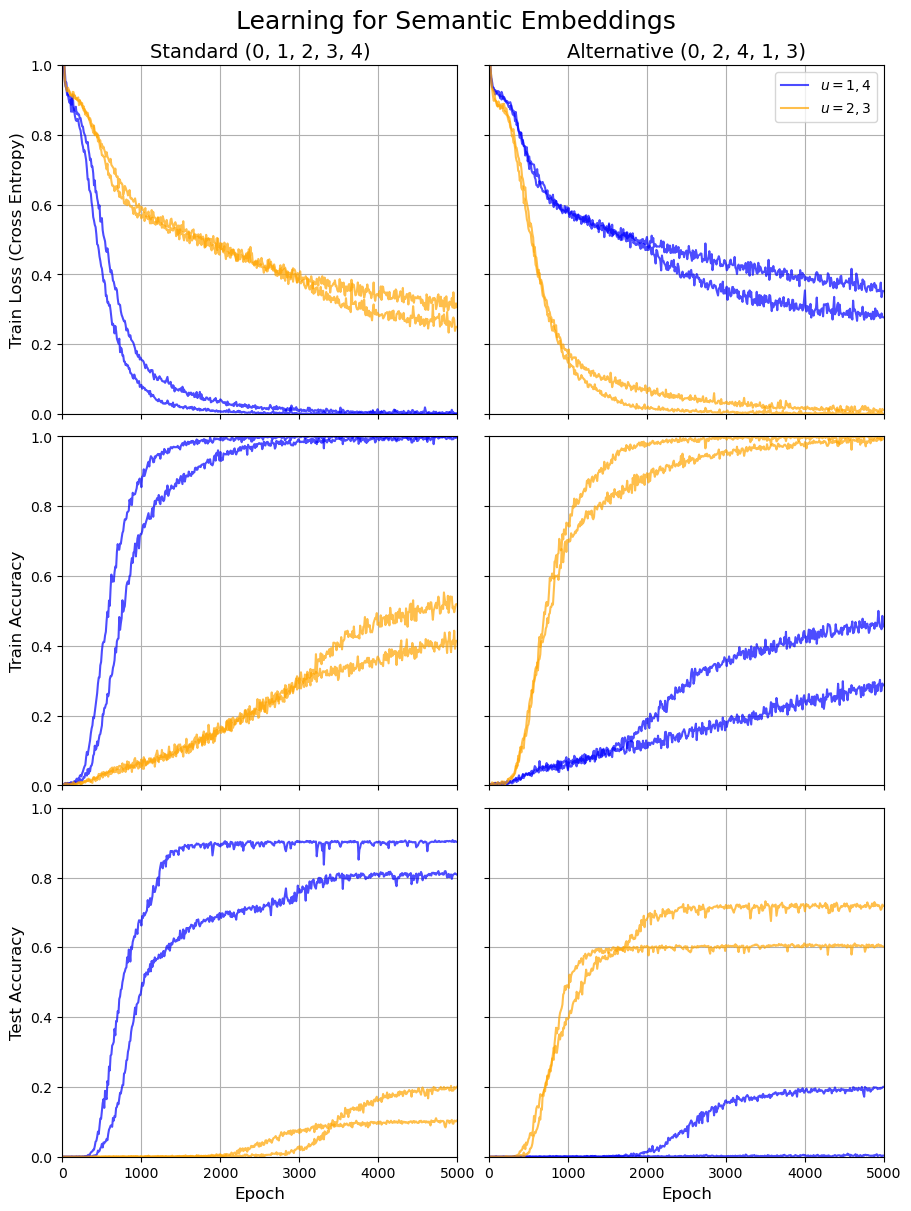

In [774]:
# create subplots, title figure
fig, axes = plt.subplots(3, 2, figsize=(9, 12), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Learning for Semantic Embeddings', fontsize=18)

b = 5
for i in range(2):
    for j in range(3):

        # get b, learning Speeds
        u = i + 1
        with open(f'../pickles/learning_metrics/learning_metrics5_semantic{u}_RNN3b.pickle', 'rb') as f:
            learning_metrics = pickle.load(f)

        # get ax, set basic formatting
        ax = axes[j, i]
        ax.grid(True)
        ax.set_xlim(0, 500)
        ax.set_ylim(0)
        ax.set_xticks(np.linspace(0, 500, 6), np.linspace(0, 5000, 6).astype('int'))

        # loss plot
        if j == 0:
            if i == 0:
                ax.set_title('Standard (0, 1, 2, 3, 4)', fontsize=14)
            if i == 1:
                ax.set_title('Alternative (0, 2, 4, 1, 3)', fontsize=14)
            for dc in learning_metrics.keys():
                loss = learning_metrics[dc]['loss']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    std, = ax.plot(loss, color='blue', alpha=0.7, label='$u=1, 4$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    alt, = ax.plot(loss, color='orange', alpha=0.7, label='$u=2, 3$')
            if i == 0:
                ax.set_ylabel('Train Loss (Cross Entropy)', fontsize=12)
            elif i == 1:
                ax.legend(handles=[std, alt])
    
        # training accuracy plot
        if j == 1:
            for dc in learning_metrics.keys():
                train_acc = learning_metrics[dc]['training_acc']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    ax.plot(train_acc, color='blue', alpha=0.7, label='$u=1$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    ax.plot(train_acc, color='orange', alpha=0.7, label='$u=2, 3$')
            if i == 0:
                ax.set_ylabel('Train Accuracy', fontsize=12)
    
        # testing accuracy plot
        if j == 2:
            for dc in learning_metrics.keys():
                test_acc = learning_metrics[dc]['testing_acc']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    ax.plot(test_acc, color='blue', alpha=0.7, label='$u=1, 4$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    ax.plot(test_acc, color='orange', alpha=0.7, label='$u=2, 3$')
            ax.set_xlabel('Epoch', fontsize=12)
            if i == 0:
                ax.set_ylabel('Test Accuracy', fontsize=12)
    plt.savefig('../figures/learning_speeds_ordering.png', dpi=300)

## Correlate Metrics

### Fit sigmoid function to accuracy curves

In [777]:
def acc(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

In [778]:
base = 5
with open(f'../pickles/learning_metrics/learning_metrics{base}_RNN_10trials.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

In [779]:
best_dc = -1
min_err = math.inf
all_errs = []
R2s = []
for base in range(3, 6):
    with open(f'../pickles/learning_metrics/learning_metrics{base}_RNN_10trials.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    for dc in learning_metrics.keys():
        x = np.arange(500)
        y = learning_metrics[dc]['testing_acc']
        try:
            (a, b, c), cov = curve_fit(acc, x, y)
        except:
            continue
        err = np.sum((y - acc(x, a, b, c))**2)
        var = np.sum((y - y.mean())**2)
        R2 = 1 - err/var
        R2s.append(R2)
        all_errs.append(err)
        if (err < min_err) and (np.max(y) > 0.8):
            min_err = err
            best_dc = dc
            print(R2)

0.9759830381890191
0.9834784941220558
0.9852279380349538
0.9900980037501085


/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_66735/4099419075.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c)))


In [780]:
all_errs = np.array(all_errs)
all_errs.mean()

np.float64(0.3238407182391095)

In [781]:
all_errs.std()

np.float64(0.3318426127142718)

In [782]:
R2s = np.array(R2s)
R2s.mean()

np.float64(0.9370223389256158)

In [783]:
R2s.std()

np.float64(0.035372989000492454)

In [784]:
x = np.arange(500)
y = learning_metrics[best_dc]['testing_acc']
N = np.where(y >= np.max(y))[0][0]
xN = x[:N]
yN = y[:N]
(a, b, c), cov = curve_fit(acc, xN, yN)

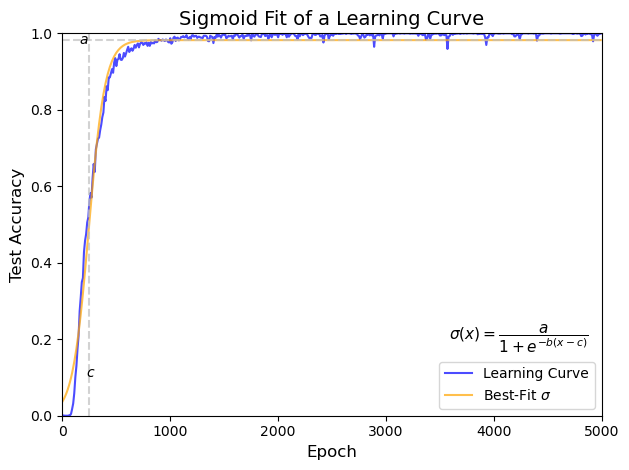

In [786]:
fig = plt.figure()
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.xticks(np.linspace(0, 500, 6), np.linspace(0, 5000, 6).astype('int'))
plt.plot(y, color='blue', alpha=0.7, label='Learning Curve')
plt.plot(acc(x, a, b, c), color='orange', alpha=0.7, label=r'Best-Fit $\sigma$')
plt.axvline(c, color='silver', alpha=0.7, linestyle='--')
plt.text(c-2.5, 0.1, '$c$')
plt.axhline(a, color='silver', alpha=0.7, linestyle='--')
plt.text(15, a-0.01, '$a$')
plt.text(0.71, 0.28, r'$\sigma(x) = \dfrac{a}{1+e^{-b(x-c)}}$', fontsize=11, transform=fig.transFigure)
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Sigmoid Fit of a Learning Curve', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/sigmoid_fit.png', dpi=300)

### Get all metrics

In [814]:
with open('../pickles/complexity_measures/est_dim_box_vs_depth.pickle', 'rb') as f:
    est_dim_box_vs_depth = pickle.load(f)

In [815]:
with open('../pickles/complexity_measures/associativity_d6.pickle', 'rb') as f:
    all_associativity = pickle.load(f)

In [816]:
with open('../pickles/complexity_measures/frac_zeros_vs_depth.pickle', 'rb') as f:
    all_frac_zeros = pickle.load(f)

In [817]:
with open('../pickles/complexity_measures/num_digits_vs_depth.pickle', 'rb') as f:
    all_num_digits = pickle.load(f)

In [818]:
all_est_dims = {}
all_critical_pts = {}

for base in range(3, 6):
    x = np.arange(500)
    with open(f'../pickles/learning_metrics/learning_metrics{base}_RNN_10trials.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    est_dims = [est_dim_box_vs_depth[base][dc][3] for dc in all_tables[base].keys()]
    critical_pts = []
    for dc in all_tables[base].keys():
        # create x and y
        x = np.arange(500)
        y = learning_metrics[dc]['testing_acc']
        # crop x and y
        N = np.where(y >= np.max(y))[0][0]
        x = x[:N]
        y = y[:N]
        try:
            (a, b, c), cov = curve_fit(acc, x, y)
        except:
            c = -1
            a = -1
        # # append only if non-unit carry
        # if len(np.unique(fn.construct_table(dc))) == 2:
        #     c = -1
        c = learning_metrics[dc]['testing_acc'].max()
        critical_pts.append(c)
    all_est_dims[base] = est_dims
    all_critical_pts[base] = critical_pts

/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_66735/4099419075.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c)))


In [819]:
# check percentage of acc curves without best-fit
temp = []
for b in range(3, 6):
    temp += all_critical_pts[b]
invalid, = np.where(np.array(temp) < 0)
len(invalid) / len(temp)

0.0

In [820]:
valid = lambda x: x > 0
for b in range(3, 6):
    critical_pts = all_critical_pts[b]
    est_dims = all_est_dims[b]
    associativity = list(all_associativity[b].values())
    # frac_zeros = [all_frac_zeros[b][dc][0] for dc in all_tables[b].keys()]
    frac_zeros = [sum(all_frac_zeros[b][dc]) / len(all_frac_zeros[b][dc]) for dc in all_tables[b].keys()]
    num_digits = [all_num_digits[b][dc][0] for dc in all_tables[b].keys()]
    valid_tuples = [(crit_pt, est_dim, frac_assoc, frac_zero, num_digit) for crit_pt, est_dim, frac_assoc, frac_zero, num_digit
                    in zip(critical_pts, est_dims, associativity, frac_zeros, num_digits) if valid(crit_pt)]
    critical_pts = [crit_pt for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    est_dims = [est_dim for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    associativity = [frac_assoc for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    frac_zeros = [frac_zero for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    num_digits = [num_digit for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    all_critical_pts[b] = critical_pts
    all_est_dims[b] = est_dims
    all_associativity[b] = associativity
    all_frac_zeros[b] = frac_zeros
    all_num_digits[b] = num_digits

In [794]:
# divide critical points by min. across base
for b in range(3, 6):
    all_critical_pts[b] = list(all_critical_pts[b] / np.min(all_critical_pts[b]))

In [821]:
# get flattened arrays on which to compute statistics
associativity_flat = []
est_dims_flat = []
critical_pts_flat = []
frac_zeros_flat = []
num_digits_flat = []
for b in all_est_dims.keys():
    est_dims_flat += all_est_dims[b]
    critical_pts_flat += all_critical_pts[b]
    associativity_flat += all_associativity[b]
    frac_zeros_flat += all_frac_zeros[b]
    num_digits_flat += all_num_digits[b]

In [822]:
# convert to arrays
for b in range(3, 6):
    all_critical_pts[b] = np.array(all_critical_pts[b])
    all_est_dims[b] = np.array(all_est_dims[b])
    all_associativity[b] = np.array(all_associativity[b])
    all_frac_zeros[b] = np.array(all_frac_zeros[b])
    all_num_digits[b] = np.array(all_num_digits[b])

In [823]:
# get carry freq by subtracting number of zeros from 1
all_carry_freq = {}
for b in range(3, 6):
    all_carry_freq[b] = 1 - all_frac_zeros[b]
carry_freq_flat = 1 - np.array(frac_zeros_flat)

In [824]:
# get indices of special non-unit carries
unit_inds = {}
special_inds = {}
non_unit_inds = {}
for b in range(3, 6):
    unit_inds[b], = np.where(np.array(all_est_dims[b]) < 1.25)
    special_inds[b], = np.where((np.array(all_est_dims[b]) >= 1.25) & (np.array(all_est_dims[b]) < 1.5))
    non_unit_inds[b], = np.where(np.array(all_est_dims[b]) >= 1.5)

### Correlations Between Measures

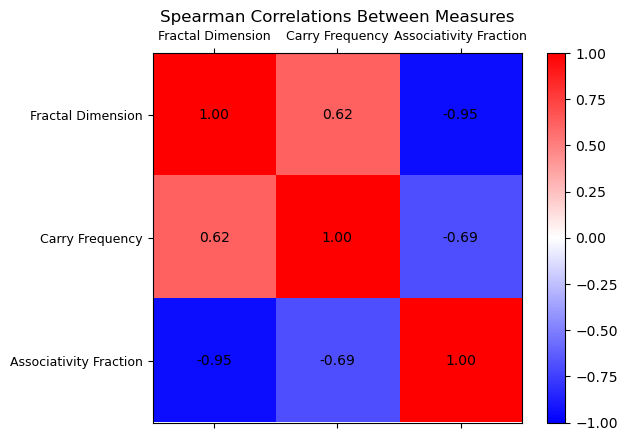

In [188]:
from scipy.stats import spearmanr
corr_matrix, _ = spearmanr([est_dims_flat, carry_freq_flat, associativity_flat], axis=1)

# plotting
fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='bwr', vmin=-1, vmax=1)
fig.colorbar(cax)

# set axis ticks and labels
labels = ['Fractal Dimension', 'Carry Frequency', 'Associativity Fraction']
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels, fontsize=9)
ax.set_yticklabels(labels, fontsize=9)

# annotate with correlation values
for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{corr_matrix[i, j]:.2f}', va='center', ha='center', color='black')

plt.title('Spearman Correlations Between Measures')
plt.savefig('../figures/correlation_matrix.png', dpi=300, bbox_inches='tight')

### Correlation to 1st PC of Measures

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [75]:
complexity = np.column_stack((est_dims_flat, carry_freq_flat, associativity_flat))

# standardize the data
scaler = StandardScaler()
complexity_standardized = scaler.fit_transform(complexity)

# perform PCA
pca = PCA(n_components=1)  # extract only the first principal component
pc1_flat = pca.fit_transform(complexity_standardized).ravel()

In [76]:
all_pc1 = {}
t = 0
for b in range(3, 6):
    l = len(all_carry_freq[b])
    all_pc1[b] = pc1_flat[t:t+l]
    t += l

In [77]:
r = scipy.stats.spearmanr(pc1_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(pc1_flat, critical_pts_flat).pvalue

Text(0.5, 1.0, 'Correlation Between 1st Principal Component and Learning Speed')

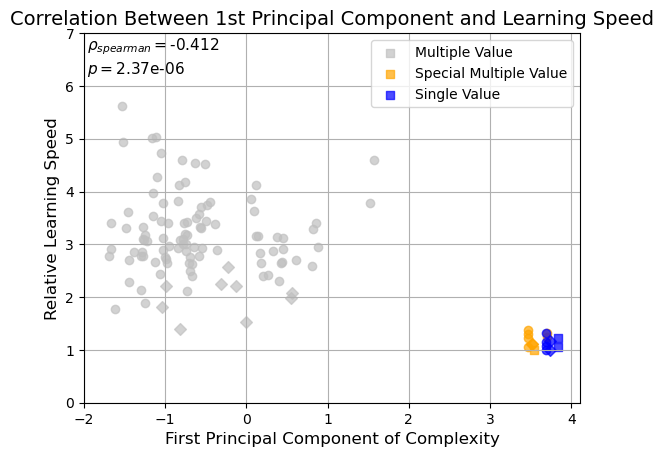

In [78]:
fig = plt.figure()
# plot non-units (w/o special)
plt.scatter(all_pc1[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Multiple Value')
plt.scatter(all_pc1[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
plt.scatter(all_pc1[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
plt.scatter(all_pc1[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Special Multiple Value')
plt.scatter(all_pc1[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
plt.scatter(all_pc1[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
plt.scatter(all_pc1[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
plt.scatter(all_pc1[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
plt.scatter(all_pc1[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
plt.legend(loc = 'upper right')
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
plt.text(0.13, 0.795, text, fontsize=11, transform=fig.transFigure)
plt.xticks(np.linspace(-2, 4, 7))
plt.yticks(np.linspace(0, 7, 8))
plt.grid(True)
plt.xlabel('First Principal Component of Complexity', fontsize=12)
plt.ylabel('Relative Learning Speed', fontsize=12)
plt.title('Correlation Between 1st Principal Component and Learning Speed', fontsize=14)
# plt.savefig('../figures/correlation_1st_PC.png', dpi=300)

### Correlate learning speed and complexity measures

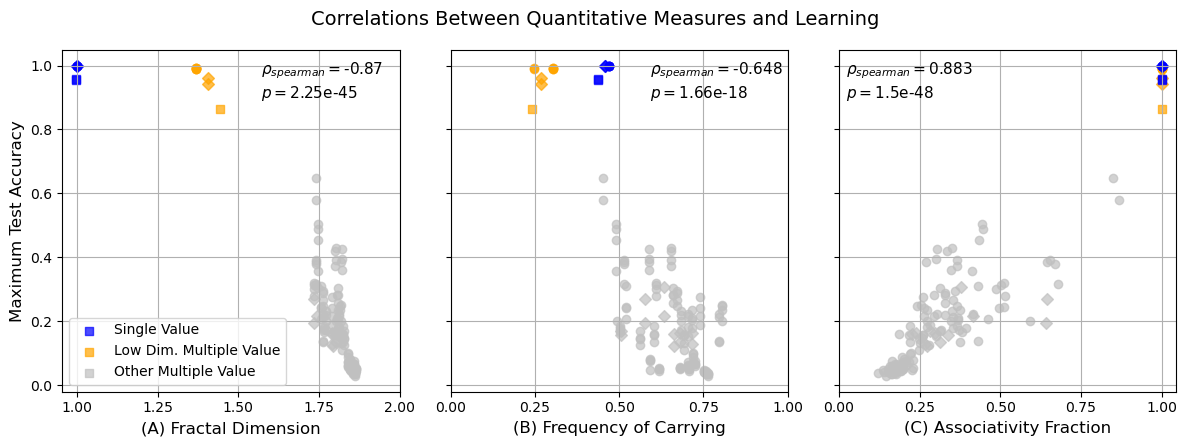

In [825]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

# correlate estimated box-counting dimension with learning speed
r = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).pvalue
# plot non-units (w/o special)
non_units = axes[0].scatter(all_est_dims[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Other Multiple Value')
axes[0].scatter(all_est_dims[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
axes[0].scatter(all_est_dims[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
special_non_units = axes[0].scatter(all_est_dims[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Low Dim. Multiple Value')
axes[0].scatter(all_est_dims[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
axes[0].scatter(all_est_dims[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
units = axes[0].scatter(all_est_dims[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
axes[0].scatter(all_est_dims[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
axes[0].scatter(all_est_dims[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
# axes[0].text(0.02, 0.86, text, fontsize=11, transform=axes[0].transAxes)
axes[0].text(0.59, 0.86, text, fontsize=11, transform=axes[0].transAxes)
axes[0].set_xticks(np.linspace(1, 2, 5))
# axes[0].set_yticks(np.linspace(0, 6, 7))
axes[0].set_yticks(np.linspace(0, 1, 6))
axes[0].grid(True) 
axes[0].set_xlabel('(A) Fractal Dimension', fontsize=12)
# axes[0].set_ylabel(r'Fitted Critical Point ($c$; normalized for each base)', fontsize=12)
# axes[0].set_ylabel(r'Fitted Upper Asymptote ($a$)', fontsize=12)
axes[0].set_ylabel('Maximum Test Accuracy', fontsize=12)
axes[0].legend(handles=[units, special_non_units, non_units], loc='lower left')

# correlate with Frequency of Carrying
r = scipy.stats.spearmanr(carry_freq_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(carry_freq_flat, critical_pts_flat).pvalue
# plot non-units (w/o special)
axes[1].scatter(all_carry_freq[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Other Multiple Value')
axes[1].scatter(all_carry_freq[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
axes[1].scatter(all_carry_freq[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
axes[1].scatter(all_carry_freq[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Low Dim. Multiple Value')
axes[1].scatter(all_carry_freq[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
axes[1].scatter(all_carry_freq[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
axes[1].scatter(all_carry_freq[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
axes[1].scatter(all_carry_freq[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
axes[1].scatter(all_carry_freq[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
# axes[1].text(0.02, 0.86, text, fontsize=11, transform=axes[1].transAxes)
axes[1].text(0.59, 0.86, text, fontsize=11, transform=axes[1].transAxes)
axes[1].set_xticks(np.linspace(0, 1, 5))
axes[1].grid(True)
axes[1].set_xlabel('(B) Frequency of Carrying', fontsize=12)

# correlate associativity fraction with learning speed
r = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).pvalue
# plot non-units (w/o special)
non_units = axes[2].scatter(all_associativity[3][non_unit_inds[3]], all_critical_pts[3][non_unit_inds[3]], marker='s', alpha=0.7, color='silver', label='Other Multiple Value')
axes[2].scatter(all_associativity[4][non_unit_inds[4]], all_critical_pts[4][non_unit_inds[4]], marker='D', alpha=0.7, color='silver')
axes[2].scatter(all_associativity[5][non_unit_inds[5]], all_critical_pts[5][non_unit_inds[5]], marker='o', alpha=0.7, color='silver')
# plot special non-units
special_non_units = axes[2].scatter(all_associativity[3][special_inds[3]], all_critical_pts[3][special_inds[3]], marker='s', alpha=0.7, color='orange', label='Low Dim. Multiple Value')
axes[2].scatter(all_associativity[4][special_inds[4]], all_critical_pts[4][special_inds[4]], marker='D', alpha=0.7, color='orange')
axes[2].scatter(all_associativity[5][special_inds[5]], all_critical_pts[5][special_inds[5]], marker='o', alpha=0.7, color='orange')
# plot units
units = axes[2].scatter(all_associativity[3][unit_inds[3]], all_critical_pts[3][unit_inds[3]], marker='s', alpha=0.7, color='blue', label='Single Value')
axes[2].scatter(all_associativity[4][unit_inds[4]], all_critical_pts[4][unit_inds[4]], marker='D', alpha=0.7, color='blue')
axes[2].scatter(all_associativity[5][unit_inds[5]], all_critical_pts[5][unit_inds[5]], marker='o', alpha=0.7, color='blue')
# formatting
text = r'$\rho_{spearman} =$' + f'{r:.3g}\n' + r'$p =$' + f'{p:.3g}'
# axes[2].text(0.02, 0.03, text, fontsize=11, transform=axes[2].transAxes)
axes[2].text(0.02, 0.86, text, fontsize=11, transform=axes[2].transAxes)
axes[2].set_xticks(np.linspace(0, 1, 5))
axes[2].grid(True)
axes[2].set_xlabel('(C) Associativity Fraction', fontsize=12)
# axes[2].legend(handles=[units, special_non_units, non_units], loc='upper right')

fig.suptitle('Correlations Between Quantitative Measures and Learning', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/correlations_max_acc.png', dpi=300)

### Associativity Fraction vs Depth

In [57]:
with open('../pickles/complexity_measures/associativity_vs_depth_d6.pickle', 'rb') as f:
    associativity_vs_depth = pickle.load(f)

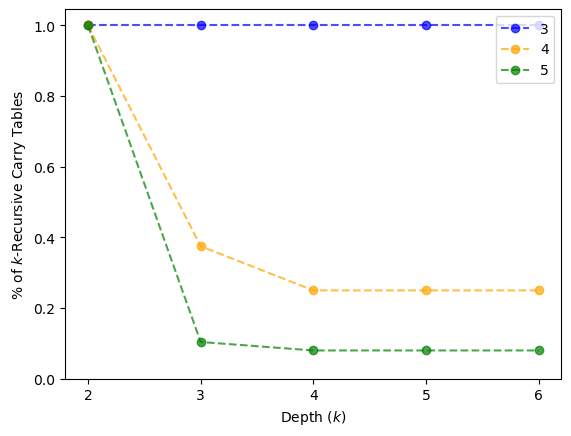

In [58]:
fig = plt.figure()

# plot percent of carry tables that are associative vs depth
depths = [2, 3, 4, 5, 6]
# base 3
stacked_assoc = np.stack(list(associativity_vs_depth[3].values()))
pct_assoc = np.mean(stacked_assoc == 1, axis=0)
plt.plot(depths, pct_assoc, alpha=0.7, marker='o', linestyle='--', color='blue', label=3)
# base 4
stacked_assoc = np.stack(list(associativity_vs_depth[4].values()))
pct_assoc = np.mean(stacked_assoc == 1, axis=0)
plt.plot(depths, pct_assoc, alpha=0.7, marker='o', linestyle='--', color='orange', label=4)
# base 5
stacked_assoc = np.stack(list(associativity_vs_depth[5].values()))
pct_assoc = np.mean(stacked_assoc == 1, axis=0)
plt.plot(depths, pct_assoc, alpha=0.7, marker='o', linestyle='--', color='green', label=5)

# formatting
plt.xticks(depths)
plt.yticks(np.linspace(0, 1, 6))
plt.xlabel(r'Depth ($k$)')
plt.ylabel(r'% of $k$-Recursive Carry Tables')
plt.legend(loc='upper right')
plt.savefig('../figures/pct_k-recursive.png', dpi=300)

### Generalization

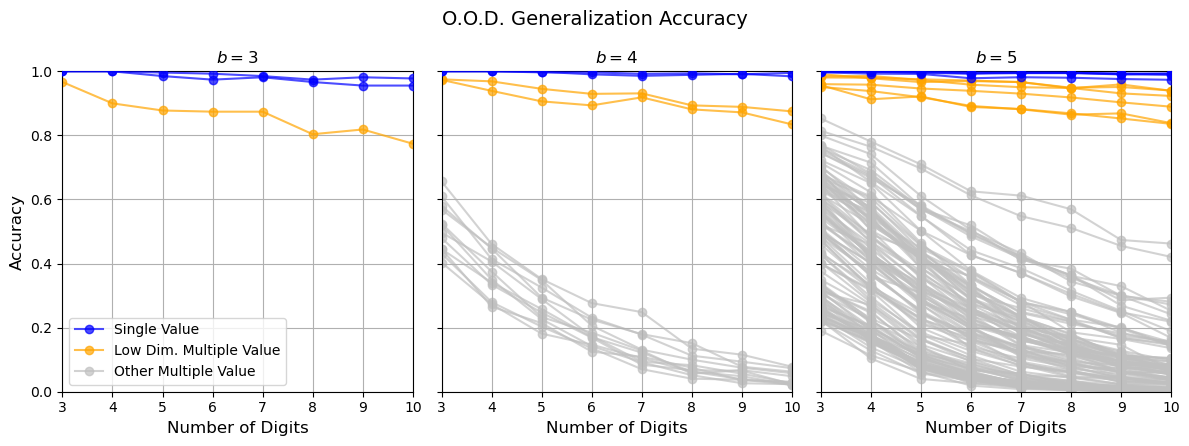

In [861]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

for i, b in enumerate(range(3, 6)):

    # open OOD metrics
    with open(f'../pickles/learning_metrics/learning_metrics{b}_ood10_LSTM_10trials.pickle', 'rb') as f:
        ood_learning_metrics = pickle.load(f)

    # plot OOD metrics
    ax = axes[i]
    for dc, ood_accs in ood_learning_metrics.items():
        est_dim = est_dim_box_vs_depth[b][dc][3]
        if len(np.unique(all_tables[b][dc])) == 2:
            unit, = ax.plot(ood_accs, color='blue', alpha=0.7, marker='o', label='Single Value', zorder=3)
            # if ood_accs[7] < 0.9:
            #     import pdb; pdb.set_trace()
        elif est_dim > 1.25 and est_dim < 1.5:
            special_non_unit, = ax.plot(ood_accs, color='orange', alpha=0.7, marker='o', label='Low Dim. Multiple Value', zorder=2)
        else:
            non_unit, = ax.plot(ood_accs, color='silver', alpha=0.7, marker='o', label='Other Multiple Value', zorder=1)

    # subplot formatting
    ax.grid(True)
    ax.set_xlim(0, 7)
    ax.set_xticks(np.linspace(0, 7, 8), np.linspace(3, 10, 8).astype('int'))
    ax.set_xlabel('Number of Digits', fontsize=12)
    ax.set_title(f'$b={b}$', fontsize=12)

# general formatting
axes[0].set_ylim(0, 1)
axes[0].set_yticks(np.linspace(0, 1, 6))
axes[0].set_ylabel('Accuracy', fontsize=12)
fig.suptitle('O.O.D. Generalization Accuracy', fontsize=14)
axes[0].legend(handles=[unit, special_non_unit, non_unit], loc='lower left')
plt.tight_layout()
plt.savefig('../figures/ml/ood_generalization.png', dpi=300)

NameError: name 'b4' is not defined

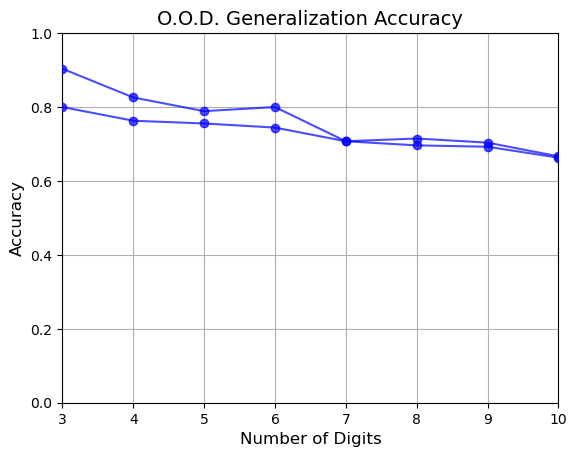

In [876]:
fig = plt.figure()

# plot single value carry functions for each base
for b in range(3, 4):

    # open OOD metrics
    with open(f'../pickles/learning_metrics/learning_metrics{b}_ood10_semantic_GRU_10trials.pickle', 'rb') as f:
        ood_learning_metrics = pickle.load(f)

    # plot OOD metrics
    for dc, ood_accs in ood_learning_metrics.items():
        est_dim = est_dim_box_vs_depth[b][dc][3]
        if b == 3:
            b3, = plt.plot(ood_accs, color='blue', alpha=0.7, marker='o', label=r'$b=3$', zorder=3)
        elif b == 4:
            b4, = plt.plot(ood_accs, color='orange', alpha=0.7, marker='o', label=r'$b=4$', zorder=2)
        else:
            b5, = plt.plot(ood_accs, color='silver', alpha=0.7, marker='o', label=r'$b=5$', zorder=1)

# formatting
plt.grid(True)
plt.xlim(0, 7)
plt.xticks(np.linspace(0, 7, 8), np.linspace(3, 10, 8).astype('int'))
plt.xlabel('Number of Digits', fontsize=12)
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 6))
plt.ylabel('Accuracy', fontsize=12)
plt.title('O.O.D. Generalization Accuracy', fontsize=14)
plt.legend(handles=[b3, b4, b5], loc='lower left')
plt.tight_layout()
# plt.savefig('../figures/ml/ood_semantic_generalization.png', dpi=300)